In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os
from glob import glob
from tqdm import tqdm

from PIL import Image
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.applications import InceptionResNetV2
from keras import backend as K, layers
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
#More readable mapping
LESION_MAP = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous Cell Carcinoma'
}

In [3]:
isic_df = pd.read_csv('../../Skin Cancer Stuff/datasets/ISIC 2019/ISIC_2019_Training_GroundTruth.csv', index_col='image')
isic_df.head()

,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
image,,,,,,,,,
ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Searching for any empty data
isic_df.isna().sum()

MEL     0
NV      0
BCC     0
AK      0
BKL     0
DF      0
VASC    0
SCC     0
UNK     0
dtype: int64

In [5]:
#Creating a new dataframe with label targets for easy access
new_isic_dataset_columns = {
    'image_id': [],
    'target': []
}

for image_id, row in tqdm(isic_df.iterrows(), total = isic_df.shape[0]):
    #Ignoring possibilities of any repeats
    if image_id in new_isic_dataset_columns['image_id']:
        continue
        
    #ignoring squamous cell carcinoma
    scc = int(isic_df.loc[image_id]['SCC'])
    if scc:
        continue
    
    
    new_isic_dataset_columns['image_id'].append(image_id)
    mel = int(isic_df.loc[image_id]['MEL'])
    nev = int(isic_df.loc[image_id]['NV'])
    bcc = int(isic_df.loc[image_id]['BCC'])
    ak = int(isic_df.loc[image_id]['AK'])
    bkl = int(isic_df.loc[image_id]['BKL'])
    df = int(isic_df.loc[image_id]['DF'])
    vasc = int(isic_df.loc[image_id]['VASC'])
    
    #labels for each target
    if mel:
        new_isic_dataset_columns['target'].append('MEL')
    elif nev:
        new_isic_dataset_columns['target'].append('NEV')
    elif bcc:
        new_isic_dataset_columns['target'].append('BCC')
    elif ak:
        new_isic_dataset_columns['target'].append('AK')
    elif bkl:
        new_isic_dataset_columns['target'].append('BKL')
    elif df:
        new_isic_dataset_columns['target'].append('DF')
    elif vasc:
        new_isic_dataset_columns['target'].append('VASC')


100%|██████████| 25331/25331 [00:50<00:00, 504.78it/s]


In [6]:
new_isic_df = pd.DataFrame(new_isic_dataset_columns).set_index('image_id')

In [7]:
#Path to images
BASE_SKIN_DATASET = os.path.join("../../Skin Cancer Stuff/datasets/ISIC 2019")
ALL_IMAGE_PATH_MAP = {os.path.splitext(os.path.basename(x))[0]: x
                         for x in glob(os.path.join(BASE_SKIN_DATASET, '*', '*.jpg'))
                     }

#Fix the path
for k, v in ALL_IMAGE_PATH_MAP.items():
    a = ALL_IMAGE_PATH_MAP[k].replace("\\\\", "/")
    a = a.replace("\\", "/")
    ALL_IMAGE_PATH_MAP[k] = a

In [8]:
#Add path of each image to dataframe
new_isic_df['image_path'] = new_isic_df.index.map(ALL_IMAGE_PATH_MAP.get)

In [9]:
new_isic_df.head()

,target,image_path
image_id,,
ISIC_0000000,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000001,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000002,MEL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000003,NEV,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...
ISIC_0000004,MEL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...


In [10]:
new_isic_df['target'].value_counts()

NEV     12875
MEL      4522
BCC      3323
BKL      2624
AK        867
VASC      253
DF        239
Name: target, dtype: int64

<AxesSubplot:>

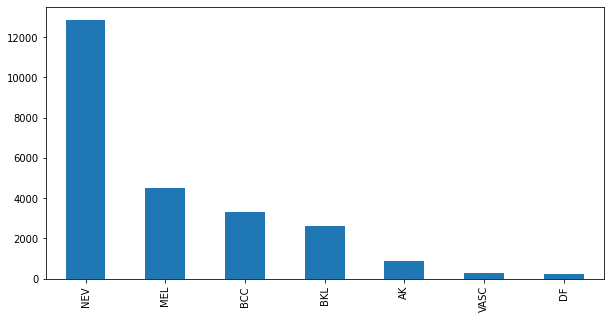

In [11]:
figure, axis_1 = plt.subplots(1, 1, figsize= (10, 5))
new_isic_df['target'].value_counts().plot(kind='bar', ax=axis_1)

# Reduce CSV, to take fewer images instead of all. And Further drop Vascular Lesions and Dermatofibroma, due to image lack

In [12]:
count = 0
for index, row in new_isic_df.iterrows():
    if count == 9552:
        break
    if row["target"] == 'NEV':
        count+=1
#         print(row)
        new_isic_df.drop(index, inplace=True)
    
count = 0
for index, row in new_isic_df.iterrows():
    if count == 1199:
        break
    if row["target"] == 'MEL':
        count+=1
        new_isic_df.drop(index, inplace=True)

In [13]:
new_isic_df['target'].value_counts()

MEL     3323
BCC     3323
NEV     3323
BKL     2624
AK       867
VASC     253
DF       239
Name: target, dtype: int64

In [14]:
for index, row in new_isic_df.iterrows():
    if row['target'] == 'VASC' or row['target'] == 'DF':
        new_isic_df.drop(index, inplace=True)

In [15]:
new_isic_df['target'].value_counts()

MEL    3323
BCC    3323
NEV    3323
BKL    2624
AK      867
Name: target, dtype: int64

<AxesSubplot:>

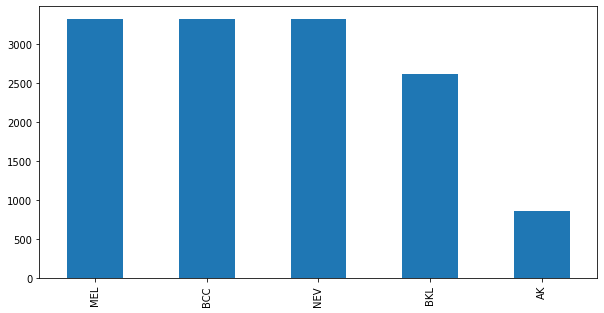

In [16]:
figure, axis_1 = plt.subplots(1, 1, figsize= (10, 5))
new_isic_df['target'].value_counts().plot(kind='bar', ax=axis_1)

In [17]:
#Adding corresponding image rows for easy access
new_isic_df['image'] = new_isic_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [18]:
new_isic_df['lesion_type_index'] = pd.Categorical(new_isic_df['target']).codes

In [19]:
new_isic_df.head()

,target,image_path,image,lesion_type_index
image_id,,,,
ISIC_0010491,BKL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...,"[[[126, 115, 113], [121, 105, 102], [90, 67, 6...",2
ISIC_0012086_downsampled,BKL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...,"[[[16, 17, 20], [16, 15, 20], [15, 15, 18], [1...",2
ISIC_0012090_downsampled,BKL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...,"[[[8, 7, 9], [18, 16, 18], [74, 65, 66], [88, ...",2
ISIC_0012103_downsampled,BKL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...,"[[[16, 19, 23], [16, 18, 23], [14, 14, 17], [1...",2
ISIC_0012117_downsampled,BKL,../../Skin Cancer Stuff/datasets/ISIC 2019/ISI...,"[[[15, 15, 15], [14, 14, 14], [12, 12, 12], [1...",2


In [20]:
#Image path can be removed, since the images are now already loaded in
del new_isic_df['image_path']

In [21]:
#x values and y values
input_features = new_isic_df.drop(columns=['lesion_type_index'],axis = 1)
labels = new_isic_df['lesion_type_index']

In [22]:
#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(input_features, labels, test_size=0.20, random_state=42)

## Train Data Normalization. Done in steps due to memory constraints

In [23]:
#convert image array into list
x_train = np.asarray(X_train['image'].tolist())

In [24]:
len(x_train)

10768

In [25]:
x_train_mean = np.mean(x_train[:500])

In [26]:
x_train_std = np.std(x_train[:500])

In [27]:
x_train[:500] = (x_train[:500] - x_train_mean) / x_train_std

In [28]:
x_train_mean = np.mean(x_train[500:1000])

In [29]:
x_train_std = np.std(x_train[500:1000])

In [30]:
x_train[500:1000] = (x_train[500:1000] - x_train_mean) / x_train_std

In [31]:
x_train_mean = np.mean(x_train[1000:1500])

In [32]:
x_train_std = np.std(x_train[1000:1500])

In [33]:
x_train[1000:1500] = (x_train[1000:1500] - x_train_mean) / x_train_std

In [34]:
x_train_mean = np.mean(x_train[1500:2000])

In [35]:
x_train_std = np.std(x_train[1500:2000])

In [36]:
x_train[1500:2000] = (x_train[1500:2000] - x_train_mean) / x_train_std

In [37]:
x_train_mean = np.mean(x_train[2000:2500])

In [38]:
x_train_std = np.std(x_train[2000:2500])

In [39]:
x_train[2000:2500] = (x_train[2000:2500] - x_train_mean) / x_train_std

In [40]:
x_train_mean = np.mean(x_train[2500:3000])

In [41]:
x_train_std = np.std(x_train[2500:3000])

In [42]:
x_train[2500:3000] = (x_train[2500:3000] - x_train_mean) / x_train_std

In [43]:
x_train_mean = np.mean(x_train[3000:3500])

In [44]:
x_train_std = np.std(x_train[3000:3500])

In [45]:
x_train[3000:3500] = (x_train[3000:3500] - x_train_mean) / x_train_std

In [46]:
x_train_mean = np.mean(x_train[3500:4000])

In [47]:
x_train_std = np.std(x_train[3500:4000])

In [48]:
x_train[3500:4000] = (x_train[3500:4000] - x_train_mean) / x_train_std

In [49]:
x_train_mean = np.mean(x_train[4000:4500])

In [50]:
x_train_std = np.std(x_train[4000:4500])

In [51]:
x_train[4000:4500] = (x_train[4000:4500] - x_train_mean) / x_train_std

In [52]:
x_train_mean = np.mean(x_train[4500:5000])

In [53]:
x_train_std = np.std(x_train[4500:5000])

In [54]:
x_train[4500:5000] = (x_train[4500:5000] - x_train_mean) / x_train_std

In [55]:
x_train_mean = np.mean(x_train[5000:5500])

In [56]:
x_train_std = np.std(x_train[5000:5500])

In [57]:
x_train[5000:5500] = (x_train[5000:5500] - x_train_mean) / x_train_std

In [58]:
x_train_mean = np.mean(x_train[5500:6000])

In [59]:
x_train_std = np.std(x_train[5500:6000])

In [60]:
x_train[5500:6000] = (x_train[5500:6000] - x_train_mean) / x_train_std

In [61]:
x_train_mean = np.mean(x_train[6000:6500])

In [62]:
x_train_std = np.std(x_train[6000:6500])

In [63]:
x_train[6000:6500] = (x_train[6000:6500] - x_train_mean) / x_train_std

In [64]:
x_train_mean = np.mean(x_train[6500:7000])

In [65]:
x_train_std = np.std(x_train[6500:7000])

In [66]:
x_train[6500:7000] = (x_train[6500:7000] - x_train_mean) / x_train_std

In [67]:
x_train_mean = np.mean(x_train[7000:7500])

In [68]:
x_train_std = np.std(x_train[7000:7500])

In [69]:
x_train[7000:7500] = (x_train[7000:7500] - x_train_mean) / x_train_std

In [70]:
x_train_mean = np.mean(x_train[7500:8000])

In [71]:
x_train_std = np.std(x_train[7500:8000])

In [72]:
x_train[7500:8000] = (x_train[7500:8000] - x_train_mean) / x_train_std

In [73]:
x_train_mean = np.mean(x_train[8000:8500])

In [74]:
x_train_std = np.std(x_train[8000:8500])

In [75]:
x_train[8000:8500] = (x_train[8000:8500] - x_train_mean) / x_train_std

In [76]:
x_train_mean = np.mean(x_train[8500:9000])

In [77]:
x_train_std = np.std(x_train[8500:9000])

In [78]:
x_train[8500:9000] = (x_train[8500:9000] - x_train_mean) / x_train_std

In [79]:
x_train_mean = np.mean(x_train[9000:9500])

In [80]:
x_train_std = np.std(x_train[9000:9500])

In [81]:
x_train[9000:9500] = (x_train[9000:9500] - x_train_mean) / x_train_std

In [82]:
x_train_mean = np.mean(x_train[9500:10000])

In [83]:
x_train_std = np.std(x_train[9500:10000])

In [84]:
x_train[9500:10000] = (x_train[9500:10000] - x_train_mean) / x_train_std

In [85]:
x_train_mean = np.mean(x_train[10000:10500])

In [86]:
x_train_std = np.std(x_train[10000:10500])

In [87]:
x_train[10000:10500] = (x_train[10000:10500] - x_train_mean) / x_train_std

In [88]:
x_train_mean = np.mean(x_train[10500:11000])

In [89]:
x_train_std = np.std(x_train[10500:11000])

In [90]:
x_train[10500:11000] = (x_train[10500:11000] - x_train_mean) / x_train_std

## Test Data Normalization

In [91]:
x_test = np.asarray(X_test['image'].tolist())

In [92]:
len(x_test)

2692

In [93]:
x_test_mean = np.mean(x_test[:500])

In [94]:
x_test_std = np.std(x_test[:500])

In [95]:
x_test[:500] = (x_test[:500] - x_test_mean) / x_test_std

In [96]:
x_test_mean = np.mean(x_test[500:1000])

In [97]:
x_test_std = np.std(x_test[500:1000])

In [98]:
x_test[500:1000] = (x_test[500:1000] - x_test_mean) / x_test_std

In [99]:
x_test_mean = np.mean(x_test[1000:1500])

In [100]:
x_test_std = np.std(x_test[1000:1500])

In [101]:
x_test[1000:1500] = (x_test[1000:1500] - x_test_mean) / x_test_std

In [102]:
x_test_mean = np.mean(x_test[1500:2000])

In [103]:
x_test_std = np.std(x_test[1500:2000])

In [104]:
x_test[1500:2000] = (x_test[1500:2000] - x_test_mean) / x_test_std

In [105]:
x_test_mean = np.mean(x_test[2000:2500])

In [106]:
x_test_std = np.std(x_test[2000:2500])

In [107]:
x_test[2000:2500] = (x_test[2000:2500] - x_test_mean) / x_test_std

In [108]:
x_test_mean = np.mean(x_test[2500:3000])

In [109]:
x_test_std = np.std(x_test[2500:3000])

In [110]:
x_test[2500:3000] = (x_test[2500:3000] - x_test_mean) / x_test_std

## Back to Regular Code

In [111]:
#One-hot encode the labels
y_train = to_categorical(Y_train, num_classes = 5)
y_test = to_categorical(Y_test, num_classes = 5)

In [112]:
#split training data into train and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [115]:
print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)

(8614, 224, 224, 3)
(8614, 5)
(2154, 224, 224, 3)
(2154, 5)
(10768,)


In [113]:
#reshape images to (224, 224, 3)
# x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
# x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
# x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

In [126]:
#Image data Augmentation
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=False
)

In [127]:
len(x_train)

8614

In [128]:
datagen.fit(x_train[:2000])

In [129]:
datagen.fit(x_train[2000:3500])

In [130]:
datagen.fit(x_train[3500:5000])

In [131]:
datagen.fit(x_train[5000:6500])

In [132]:
datagen.fit(x_train[6500:8000])

In [133]:
datagen.fit(x_train[8000:9500])

In [138]:
IMAGE_SIZE = (224, 224, 3)
BATCH_SIZE = 10
EPOCHS = 3

In [135]:
base_model = InceptionResNetV2(include_top=False, input_shape=IMAGE_SIZE, weights="imagenet")

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024)(x)
x = layers.Dropout(0.4)(x)
predictions = layers.Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [137]:
#Callback functions, to prevent overfitting, and model checkpointing
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto', verbose=1)
model_checkpoint = ModelCheckpoint('models/dense_model_{epoch:02d}-{val_accuracy:.2f}ML.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only = True)
lst_callbacks = [early_stopper, learning_rate_reduction, model_checkpoint]

In [139]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    callbacks=lst_callbacks
)

Epoch 1/3
 13/861 [..............................] - ETA: 1:38:31 - loss: 1.6499 - accuracy: 0.2923

KeyboardInterrupt: 